In [2]:
from scipy.io import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load ARFF file
data, meta = arff.loadarff("Training_Dataset.arff")

In [4]:
df = pd.DataFrame(data)

In [5]:
# Decode byte columns if needed
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)

In [6]:
# Preview
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [7]:
print("Shape:", df.shape)
df.info()
df.describe()
df.isnull().sum()
df['Result'].value_counts()

Shape: (11055, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   having_IP_Address            11055 non-null  object
 1   URL_Length                   11055 non-null  object
 2   Shortining_Service           11055 non-null  object
 3   having_At_Symbol             11055 non-null  object
 4   double_slash_redirecting     11055 non-null  object
 5   Prefix_Suffix                11055 non-null  object
 6   having_Sub_Domain            11055 non-null  object
 7   SSLfinal_State               11055 non-null  object
 8   Domain_registeration_length  11055 non-null  object
 9   Favicon                      11055 non-null  object
 10  port                         11055 non-null  object
 11  HTTPS_token                  11055 non-null  object
 12  Request_URL                  11055 non-null  object
 13  URL_of_Ancho

Result
1     6157
-1    4898
Name: count, dtype: int64

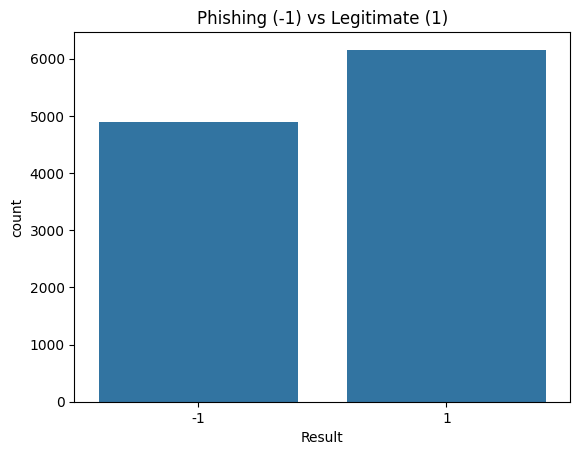

In [8]:
# Visualization - Class Distribution
sns.countplot(x='Result', data=df)
plt.title("Phishing (-1) vs Legitimate (1)")
plt.show()

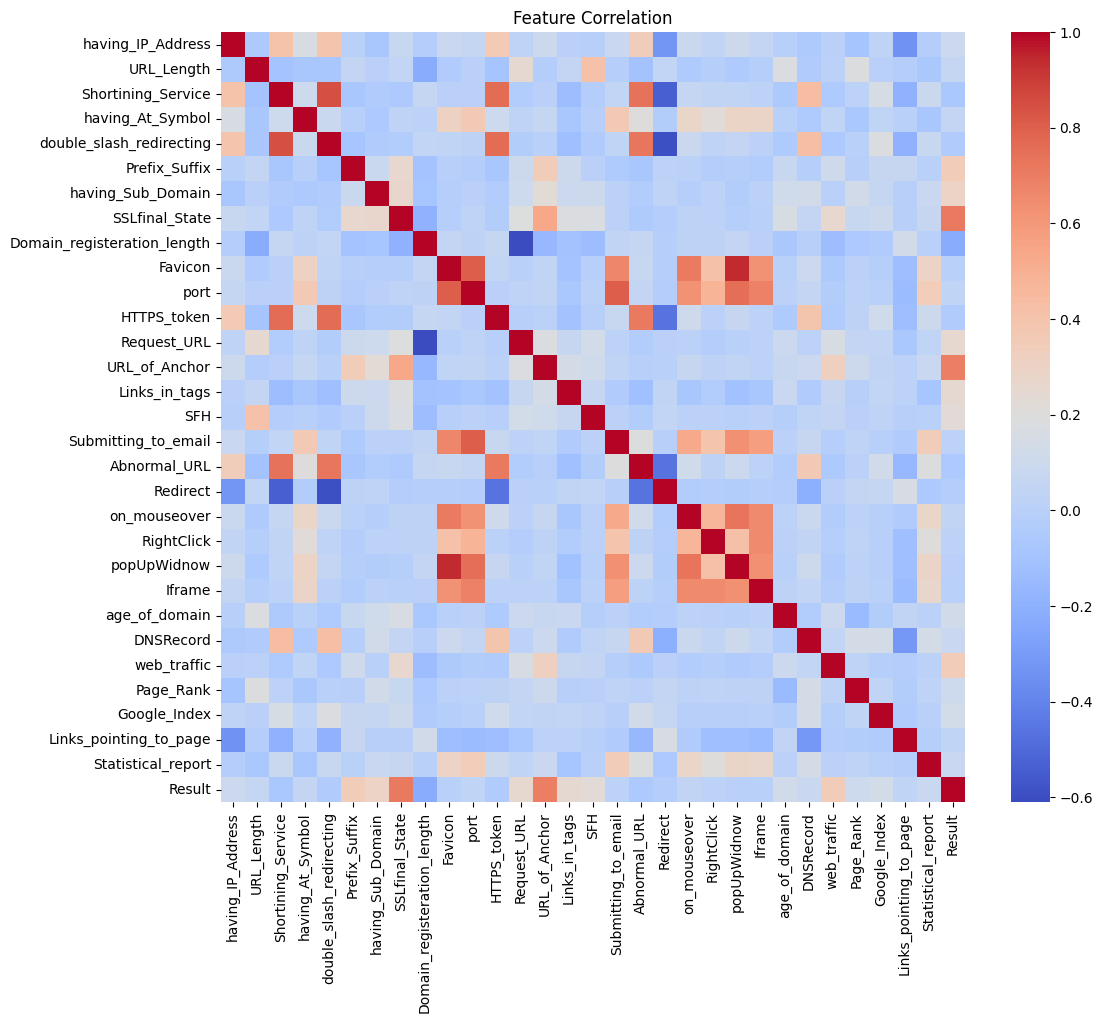

In [9]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [10]:
#Drop unwanted features 
drop_features = [
    'having_At_Symbol',
    'RightClick',
    'SFH',
    'Submitting_to_email',
    'popUpWidnow',
    'Iframe',
    'Page_Rank'
]

df = df.drop(columns=drop_features)

In [11]:
# Check correlations
correlation_matrix = df.corr()

# Remove highly correlated features
threshold = 0.9
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Drop correlated features
df = df.drop(columns=correlated_features)

In [12]:
# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

In [13]:
# Define features and target
X = df.drop(columns=['Result'])  # Assuming 'Result' is your target
y = df['Result']

In [14]:
# SelectKBest
k_best = SelectKBest(score_func=f_classif, k=20)
k_best.fit(X, y)
kbest_features = set(X.columns[k_best.get_support()])

# RFE
rfe_model = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
rfe_model.fit(X, y)
rfe_features = set(X.columns[rfe_model.support_])

# RandomForest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_features = set(importances[importances >= 0.01].index)

# Combine using majority voting
all_features = list(X.columns)
final_features = []

for feature in all_features:
    votes = sum([
        feature in kbest_features,
        feature in rfe_features,
        feature in rf_features
    ])
    if votes >= 2:  # At least 2 out of 3 methods agree
        final_features.append(feature)

print("Final selected features (at least 2 methods agree):")
print(final_features)

# Filter X with final selected features
X_reduced = X[final_features]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Final selected features (at least 2 methods agree):
['having_IP_Address', 'URL_Length', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'Abnormal_URL', 'on_mouseover', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


C:\Users\jatin\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [15]:
# Model training and evaluation
results = {}

In [16]:
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test,log_pred))
print("Classification Rport \n",classification_report(y_test,log_pred))
results['Logistic Regression'] = classification_report(y_test, log_pred, output_dict=True)

Confusion Matrix 
 [[ 860   96]
 [  80 1175]]
Classification Rport 
               precision    recall  f1-score   support

          -1       0.91      0.90      0.91       956
           1       0.92      0.94      0.93      1255

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211



In [17]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,svm_pred))
print("Classification Report: \n",classification_report(y_test,svm_pred))
results['SVM'] = classification_report(y_test, svm_pred, output_dict=True)

Confusion Matrix: 
 [[ 882   74]
 [  44 1211]]
Classification Report: 
               precision    recall  f1-score   support

          -1       0.95      0.92      0.94       956
           1       0.94      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.94      0.95      2211
weighted avg       0.95      0.95      0.95      2211



In [18]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print("Confusion Matrix: \n" ,confusion_matrix(y_test,dt_pred))
print("Classification Report: \n",classification_report(y_test,dt_pred))
results['Decision Tree'] = classification_report(y_test, dt_pred, output_dict=True)

Confusion Matrix: 
 [[ 917   39]
 [  43 1212]]
Classification Report: 
               precision    recall  f1-score   support

          -1       0.96      0.96      0.96       956
           1       0.97      0.97      0.97      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



In [19]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("Confusion Matrix: \n" , confusion_matrix(y_test,knn_pred))
print("Classification Report: \n", classification_report(y_test,knn_pred))
results['KNN'] = classification_report(y_test, knn_pred, output_dict=True)

Confusion Matrix: 
 [[ 882   74]
 [  66 1189]]
Classification Report: 
               precision    recall  f1-score   support

          -1       0.93      0.92      0.93       956
           1       0.94      0.95      0.94      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211



In [20]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Confusion Matrix: \n" ,confusion_matrix(y_test,rf_pred))
print("Classification Report: \n",classification_report(y_test,rf_pred))
results['Random Forest'] = classification_report(y_test, rf_pred, output_dict=True)

Confusion Matrix: 
 [[ 917   39]
 [  26 1229]]
Classification Report: 
               precision    recall  f1-score   support

          -1       0.97      0.96      0.97       956
           1       0.97      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



In [21]:
# Accuracy Summary
accuracy_scores = {model: round(metrics['accuracy'] * 100, 2) for model, metrics in results.items()}
accuracy_scores

{'Logistic Regression': 92.04,
 'SVM': 94.66,
 'Decision Tree': 96.29,
 'KNN': 93.67,
 'Random Forest': 97.06}

In [22]:
# Print comparison in a nice format
for model, score in accuracy_scores.items():
    print(f"{model}: {score}% accuracy")

Logistic Regression: 92.04% accuracy
SVM: 94.66% accuracy
Decision Tree: 96.29% accuracy
KNN: 93.67% accuracy
Random Forest: 97.06% accuracy


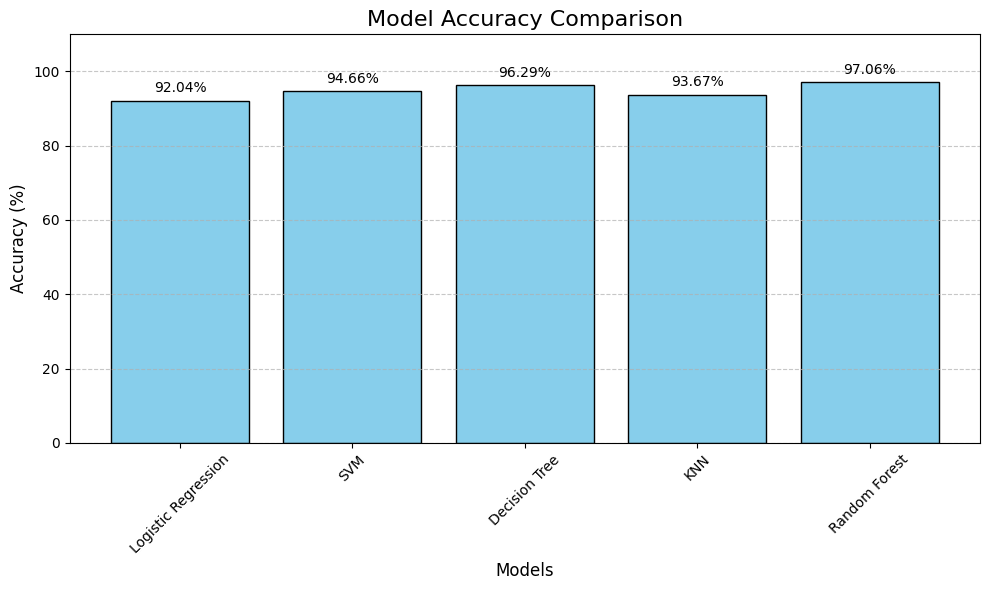

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue', edgecolor='black')

plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 110)  # Increased to prevent text overflow
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (model, acc) in enumerate(accuracy_scores.items()):
    plt.text(i, acc + 1.5, f"{acc}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Create the base models
models = [
    ('logreg', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Create a Voting Classifier (hard voting)
voting_model = VotingClassifier(estimators=models, voting='hard')

# Fit the voting classifier
voting_model.fit(X_train, y_train)

# Make predictions
voting_pred = voting_model.predict(X_test)

# Print classification report
print(classification_report(y_test, voting_pred))


# Print accuracy
accuracy = accuracy_score(y_test, voting_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

          -1       0.96      0.94      0.95       956
           1       0.96      0.97      0.96      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

Accuracy: 95.97%


Abnormal_URL                   0.005628
Statistical_report             0.006077
on_mouseover                   0.007346
HTTPS_token                    0.007473
URL_Length                     0.011269
Google_Index                   0.013711
DNSRecord                      0.014174
having_IP_Address              0.014493
Domain_registeration_length    0.016453
age_of_domain                  0.016779
Links_pointing_to_page         0.021330
Request_URL                    0.022186
Prefix_Suffix                  0.044323
Links_in_tags                  0.050256
web_traffic                    0.083660
having_Sub_Domain              0.084409
URL_of_Anchor                  0.267490
SSLfinal_State                 0.312944
dtype: float64


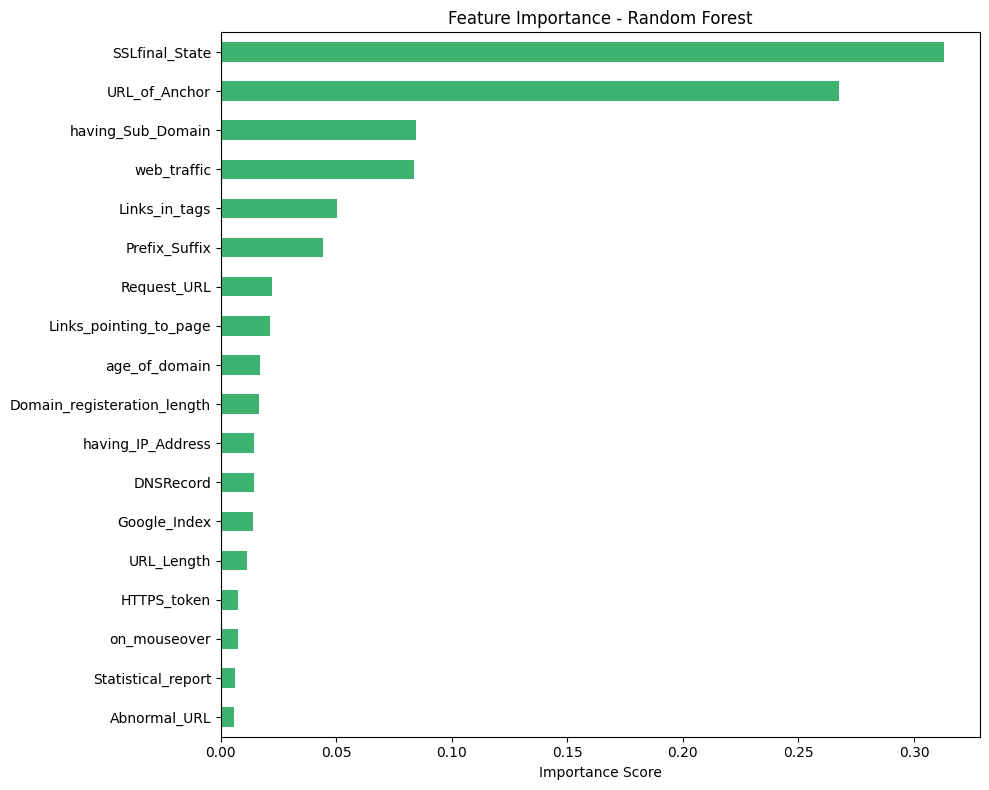

In [67]:
# Get importances
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=True)
print(importances)

# Plot
plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='mediumseagreen')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Conclusion

In this project, we analyzed the **UCI Phishing Websites Dataset** using multiple machine learning models to classify websites as **phishing** or **legitimate**. After performing data preprocessing, training, and evaluation, we compared the performance of five classification algorithms:

- **Logistic Regression**
- **Support Vector Machine (SVM)**
- **Decision Tree**
- **K-Nearest Neighbors (KNN)**
- **Random Forest**

From the above results, we can conclude that:

- **Random Forest** achieved the **highest accuracy (97.06%)**, making it the most effective model for detecting phishing websites in this case.  
- Other models like **Decision Tree (96.29%)** and **SVM (94.66%)** also performed well, but slightly lower than Random Forest.  
- Overall, ensemble methods like **Random Forest** tend to provide better generalization and robustness for such classification problems.